In [1]:
from matrixprofile import *
from matrixprofile.discords import discords

import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('KPI_new.csv')
df.head()

,timestamp,KPI
0,1535731200000,2163288
1,1535731500000,1589309
2,1535731800000,1354685
3,1535732100000,1248242
4,1535732400000,1132266


In [3]:
# 转换时间戳
df['timestamp'] = [time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(ts/1000)) for ts in df['timestamp']]
# df['timestamp'] = list(map(lambda ts:time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(ts/1000)) ,df['timestamp']))
# TypeError: unsupported operand type(s) for /: 'map' and 'int'
# 套个list并无卵用

In [4]:
df.head()

,timestamp,KPI
0,2018-09-01 00:00:00,2163288
1,2018-09-01 00:05:00,1589309
2,2018-09-01 00:10:00,1354685
3,2018-09-01 00:15:00,1248242
4,2018-09-01 00:20:00,1132266


In [5]:
df.tail()

,timestamp,KPI
4027,2018-09-14 23:35:00,1135483
4028,2018-09-14 23:40:00,1049150
4029,2018-09-14 23:45:00,1021632
4030,2018-09-14 23:50:00,1019847
4031,2018-09-14 23:55:00,929274


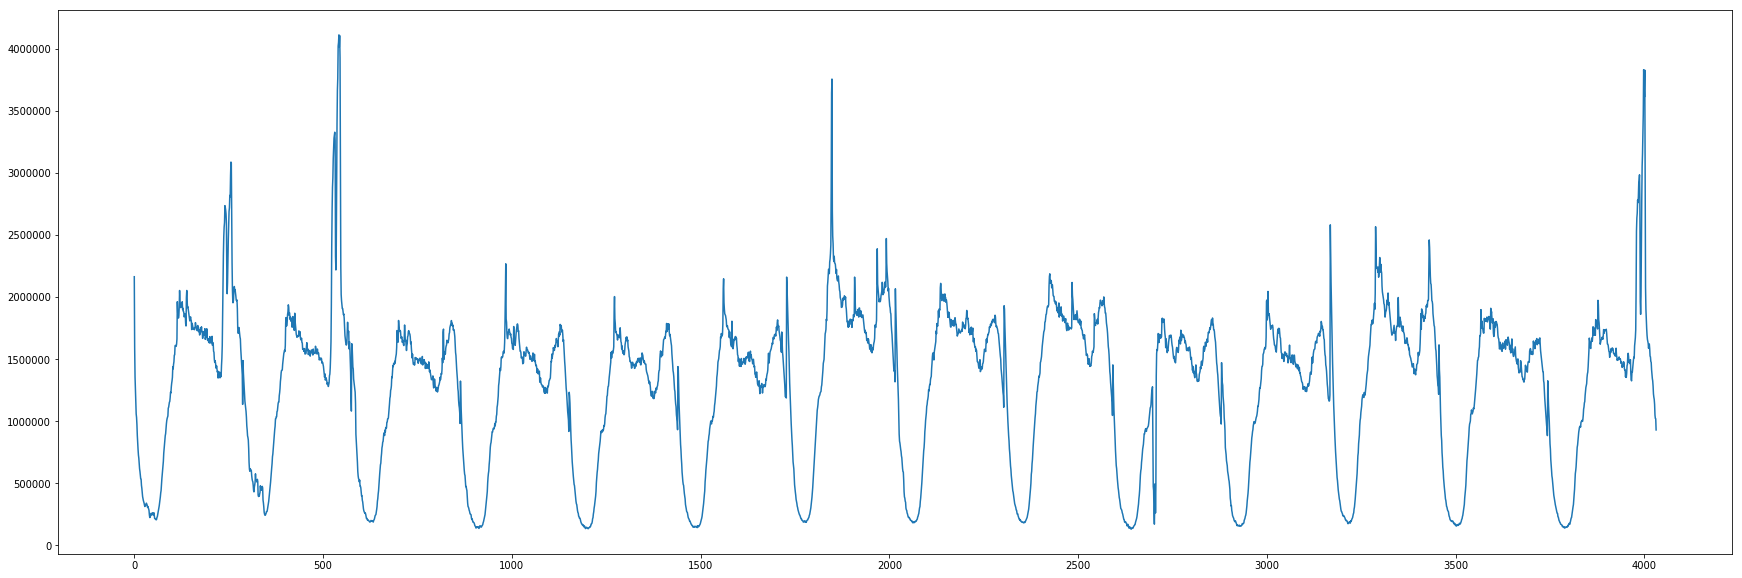

In [6]:
plt.figure(figsize=(30,10))
plt.plot(df.KPI)
plt.show()

In [7]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [8]:
df.tail()

,KPI
timestamp,
2018-09-14 23:35:00,1135483
2018-09-14 23:40:00,1049150
2018-09-14 23:45:00,1021632
2018-09-14 23:50:00,1019847
2018-09-14 23:55:00,929274


#### 以一定的时间为单位重采样

In [9]:
df = df.resample('20T').sum()
df.head()

,KPI
timestamp,
2018-09-01 00:00:00,6355524
2018-09-01 00:20:00,4192543
2018-09-01 00:40:00,3208540
2018-09-01 01:00:00,2569347
2018-09-01 01:20:00,2115723


In [10]:
# 从数组的形状中删除单维度条目，即把shape中为1的维度去掉
a = df.values.squeeze()
# 窗口大小
m = 72
profile = matrixProfile.stomp(a,m)

In [11]:
df['profile'] = np.append(profile[0], np.zeros(m-1)+np.nan)
df['profile_index'] = np.append(profile[1], np.zeros(m-1)+np.nan)

#### matrix profile 构图

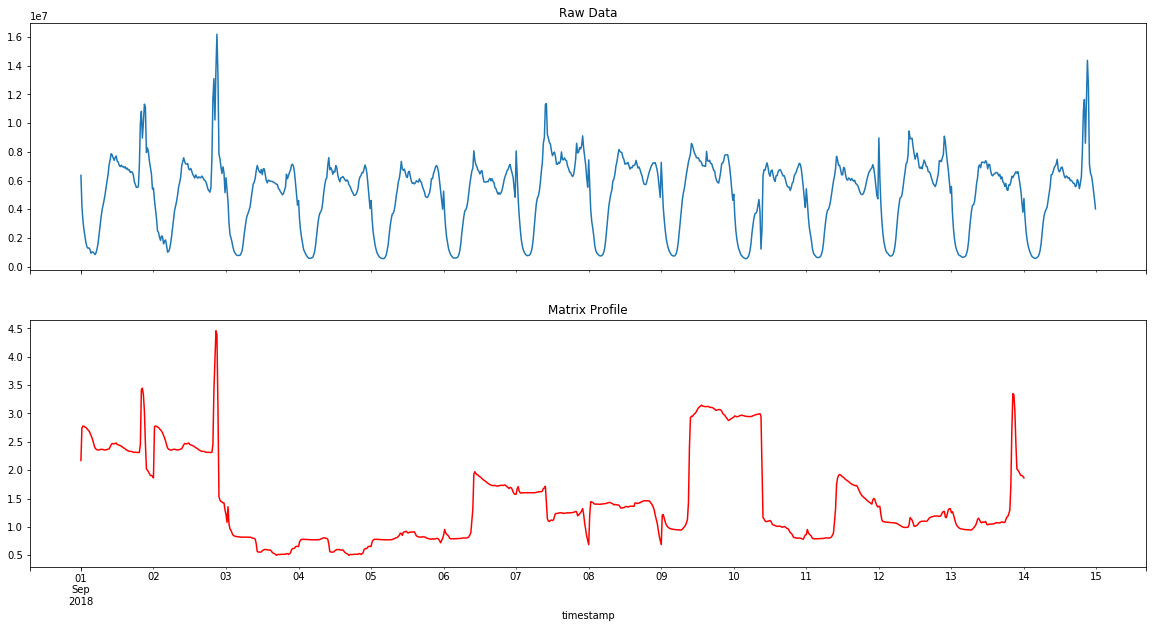

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))
df['KPI'].plot(ax=ax1, title='Raw Data')

df['profile'].plot(ax=ax2, c='r', title='Matrix Profile')
plt.show()

In [13]:
# exclude up to a day on the left and right side
ex_zone = 27

# we look for the 5 events specified in the data explaination
anoms = discords(df['profile'], ex_zone, k=10)

In [14]:
df.iloc[anoms]

,KPI,profile,profile_index
timestamp,,,
2018-09-02 20:40:00,13709934,4.459148,62.0
2018-09-01 20:20:00,8957318,3.446429,925.0
2018-09-13 20:20:00,6196339,3.349748,278.0
2018-09-09 13:20:00,7230341,3.146415,472.0
2018-09-10 08:40:00,3843051,2.995958,169.0
2018-09-09 23:20:00,5349534,2.913582,285.0
2018-09-01 00:40:00,3208540,2.778331,74.0
2018-09-02 11:20:00,7179879,2.471129,34.0
2018-09-01 10:20:00,7783784,2.470397,103.0


In [15]:
df.iloc[anoms].KPI

timestamp
2018-09-02 20:40:00    13709934
2018-09-01 20:20:00     8957318
2018-09-13 20:20:00     6196339
2018-09-09 13:20:00     7230341
2018-09-10 08:40:00     3843051
2018-09-09 23:20:00     5349534
2018-09-01 00:40:00     3208540
2018-09-02 11:20:00     7179879
2018-09-01 10:20:00     7783784
2018-09-06 10:20:00     7407922
Name: KPI, dtype: int64

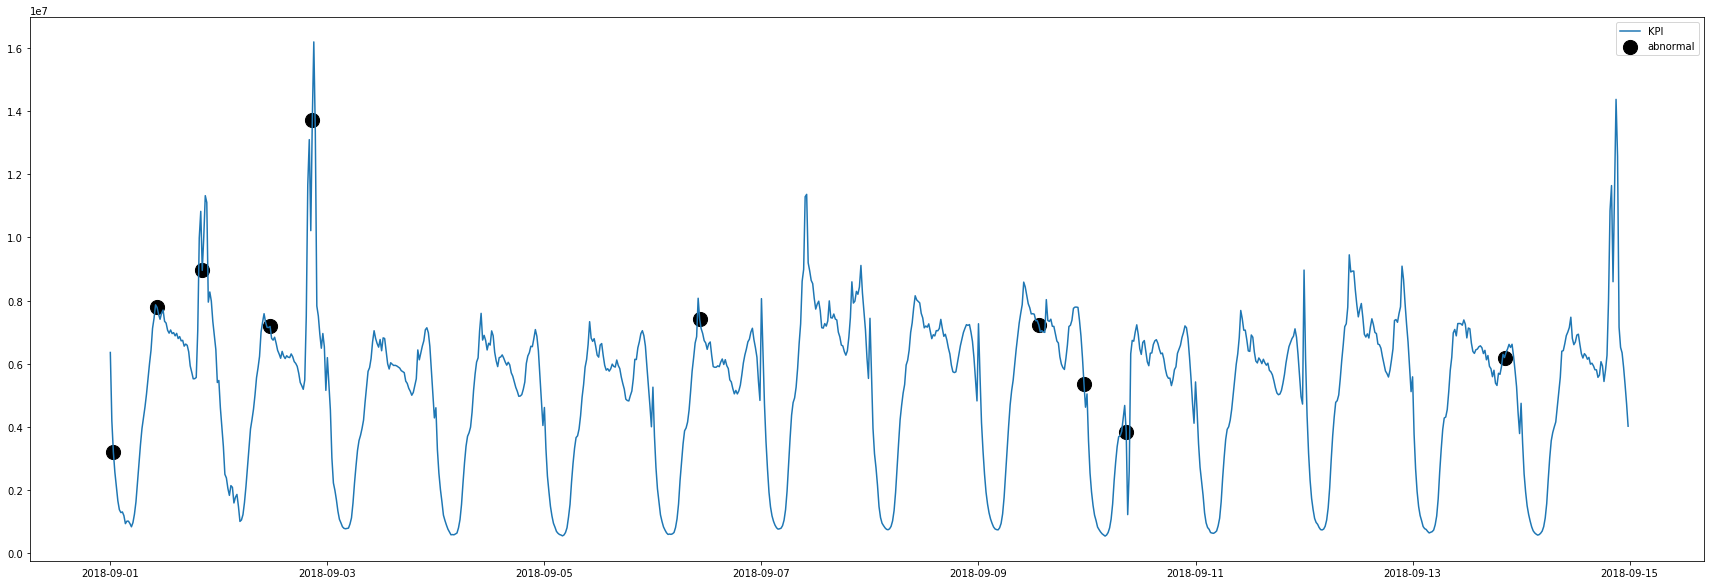

In [16]:
plt.figure(figsize=(30,10))
plt.plot(df.KPI)
plt.scatter(df.iloc[anoms].index, df.iloc[anoms].KPI, s=200, marker='o', color='black', label='abnormal')
plt.legend(loc='best')

### 计算速度很快。但是需要手动调参数：采样频率、窗口大小、异常点排斥区域、异常点个数。不同的参数组合差异很大